# Aprendizaje Automático para Datos en Grafos - Laboratorio 2
La idea de este Laboratorio es ver que algunas propiedades de la estructura de grandes redes que vimos en clase efectivamente aparecen en una red real. Además, implementaremos un par de algoritmos para hacer partición de un grafo, y los aplicaremos a un dataset real.

**La versión de numpy que viene instalada por defecto con Colab causa un error al importar graspologic. Instalamos una anterior**

In [ ]:
!pip install "numpy==1.26.4"

## Importante: reiniciar sesión
**Luego de correr la celda anterior hay que reiniciar la sesión de Colab (Menú Runtime -> Restart session)**

In [ ]:
# Instalo graspologic. Es una biblioteca que nos va a servir para más adelante,
# ahora solo vamos a utilizar un método muy útil que tiene (es como matar una
# mosca con un cañón, pero bueno)
!pip install graspologic

In [ ]:
# Instalo PyTorch Geometric
!pip install torch-geometric

In [1]:
# Importo bibliotecas
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importo la función de graspologic que quiero usar
from graspologic.utils import remap_labels

## Estructura de grandes redes

### Distribución de grados
En esta sección vamos a trabajar con la distribución de grados de un grafo real, que proviene de datos de citaciones entre papers de machine learning. Dado un grafo $G$, llamamos $p_k$ a la fracción de los vértices del grafo que tienen grado $k$. El conjunto $\{p_k\}_{k\geq 0}$ es la *distribución de grados del grafo $G$*. Por ejemplo, en el grafo de la figura:

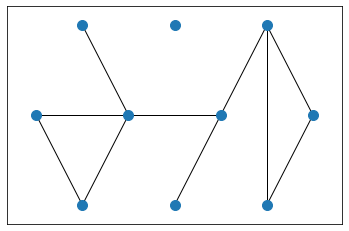

la distribución de grados es $p_0 = 1/10$, $p_1 = 2/10$, $p_2 = 4/10$, $p_3 = 2/10$, $p_4 = 1/10$ y $p_k = 0$ para todo $k>4$. Del ejemplo debería ser claro que la distribución de grados de un grafo finito cumple $p_k=0$ para todo $k$ suficientemente grande.

Notar que la distribución de grados se puede calcular simplemente como el histograma (normalizado) de la secuencia de grados del grafo, con *bins* de tamaño 1 centrados en los enteros no negativos.

1. Escribir una función que permita calcular la distribución de grados de un grafo a partir de una lista de los grados de los nodos del grafo. La función [`numpy.histogram`](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) puede ser de utilidad.

In [31]:
def degree_distribution(degree_list):
  # TODO: Implementar esta función que acepta como argumento una lista de los
  # grados de un grafo y devuelve la distribución de grados del grafo

  degree_distribution = []

  ############# Tu código acá #############
  
  bins = np.arange(0, max(degree_list) + 2)
  degree_distribution, _ = np.histogram(degree_list, density=True, bins=bins)

  #########################################

  return degree_distribution

Distribución de grados del grafo de ejemplo es [0.1 0.2 0.4 0.2 0.1]


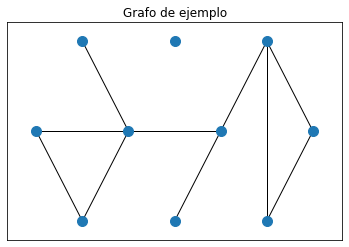

In [32]:
# Chequeemos que la función devuelva lo correcto en el grafo de ejemplo
# Armo el grafo a partir de la lista de aristas
G = nx.Graph()
nodelist = np.arange(1,11)
G.add_nodes_from(nodelist)
edgelist = [(1,2), (1,3), (2,3), (3,4), (3,6), (6,7), (6,8), (8,9), (8,10), (9,10)]
G.add_edges_from(edgelist)

# Fijo posiciones de nodos
dx = 0.5
dy = 0.5
pos = {1:(0,0),2:(dx,-dy),3:(2*dx,0),4:(dx,dx),5:(3*dx,dy),6:(4*dx,0),7:(3*dx,-dy),8:(5*dx,dy),9:(5*dx,-dy),10:(6*dx,0)}
# Dibujo el grafo
plt.figure()
plt.title('Grafo de ejemplo')
nx.draw_networkx(G,pos=pos,with_labels=False,node_size=100)

# Armo lista de grados de nodos.
degree_list = [deg for (node,deg) in G.degree()]
degree_dist = degree_distribution(degree_list)
print(f'Distribución de grados del grafo de ejemplo es {degree_dist}')

### Power-law y redes scale-free
Decimos que la distribución de grados tiene *power-law* si $p_k = Ck^{-\alpha}$. En la práctica, se observa que la distribución de grados de muchas redes del mundo real siguen una distribución power-law. En esta parte trabajaremos con una construida a partir de datos de citaciones entre papers de machine learning. Los datos provienen del paper [Automating the Construction of Internet Portals with Machine Learning](https://link.springer.com/article/10.1023/A:1009953814988). Es un grafo no dirigido, donde los nodos se corresponden a papers y si el paper $i$ cita al paper $j$ entonces hay una arista entre los nodos $i$ y $j$.

In [33]:
# Importo el dataset, que convenientemente forma parte de Torch-Geometric
from torch_geometric.datasets import Planetoid

cora_dataset = Planetoid(root='/tmp/cora', name='Cora')

In [34]:
# Algunos datos del grafo
print(f'Dataset: {cora_dataset}:')
print('======================')
print(f'Cantidad de grafos: {len(cora_dataset)}')
print(f'Cantidad de clases: {cora_dataset.num_classes}')

Dataset: Cora():
Cantidad de grafos: 1
Cantidad de clases: 7


In [35]:
# Miro el primer grafo
cora_data = cora_dataset[0]

print(cora_data)
print('==============================================================')

# Estadísticas del grafo.
print(f'Cantidad de nodos: {cora_data.num_nodes}')
print(f'Cantidad de aristas: {cora_data.num_edges}')
print(f'Grado promedio de nodo: {(2*cora_data.num_edges) / cora_data.num_nodes:.2f}')
print(f'Tiene nodos aislados: {cora_data.has_isolated_nodes()}')
print(f'Tiene self-loops: {cora_data.has_self_loops()}')
print(f'Es no dirigido: {cora_data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Cantidad de nodos: 2708
Cantidad de aristas: 10556
Grado promedio de nodo: 7.80
Tiene nodos aislados: False
Tiene self-loops: False
Es no dirigido: True


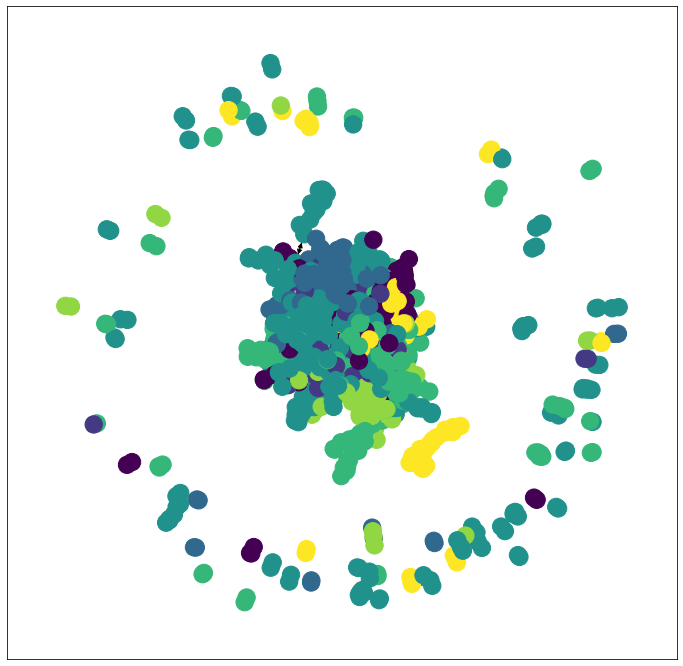

In [36]:
# Dibujo el grafo
from torch_geometric.utils import to_networkx

G_cora = to_networkx(cora_data)
plt.figure(figsize=(12,12))
cora_pos = nx.spring_layout(G_cora, seed=20)
nx.draw_networkx(G_cora,node_color=cora_data.y,pos=cora_pos,with_labels=False)

Los nodos de este grafo están divididos en 7 grupos según el tópico de cada paper. La idea de esta parte es estudiar si la distribución de grados de este grafo obedece una power-law. Para eso, notemos que si tomamos logaritmo en la igualdad $p_k = Ck^{-\alpha}$ tenemos que $\log p_k = -\alpha \log k + C$, por lo que si la distribución de grados tiene power-law, esperamos que la curva $k$ vs. $p_k$ se asemeje a una recta si la graficamos en escala logarítmica.

2. Graficar la distribución de grados como función del grado $k$, en escala logarítmica. ¿Cree que esas distribuciones siguen una ley de potencias? ¿Por qué?

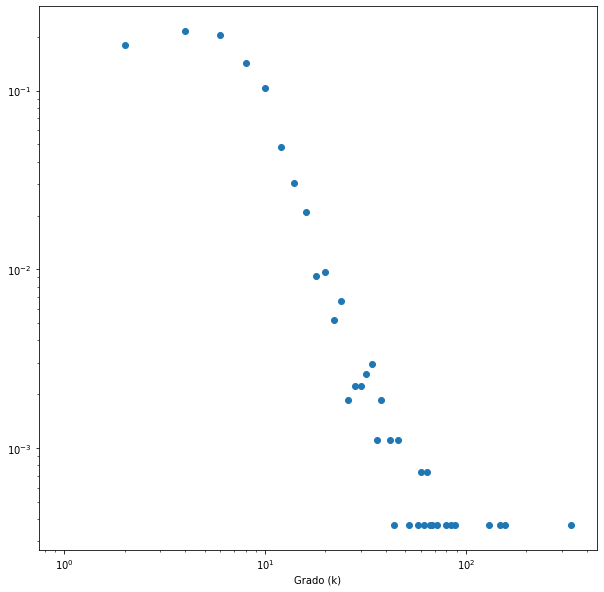

In [10]:
# Calculo distribución de grados para el grafo Cora
deg_sequence = np.array([deg for (node, deg) in G_cora.degree()])

deg_distribution = degree_distribution(deg_sequence)

# TODO: graficar la distribución de grados como función del grado k, en escala # logarítmica.

############# Tu código acá #############
plt.figure(figsize=(10,10))
plt.scatter(np.arange(deg_distribution.shape[0]), deg_distribution)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Grado (k)")
plt.show()
#########################################

En redes reales, raramente la distribución de grados sigue una ley de potencias en todo el rango de grados $k$; generalmente se observa una relación de ese tipo para valores grandes de $k$, es decir, en la cola de la distribución. En general, cuando decimos que una red tiene power-law, nos referimos a que la distribución de grados obedece una ley de potencias para valores grandes de $k$. En ese caso, decimos que la red es *scale-free* (o libre de escala).

En el gráfico de las distribuciones de grados de la red de papers debería ver que la distribución de grados tiene fluctuaciones muy grandes para valores altos de $k$, lo que no permite evaluar claramente la existencia de una ley de potencias. Eso se debe a que, a medida que aumenta el grado $k$, existen menos nodos que tienen ese grado. Por lo tanto, en cada bin del histograma de la secuencia de grados hay pocas muestras, causando el ruido que debería ver en la cola del gráfico anterior. Una posible solución consiste en agrandar los bins en la cola del histograma, para que en cada uno hayan más muestras. Por ejemplo, en lugar de usar bins linealmente equiespaciados, podríamos equiespaciarlos pero en escala logarítmica.


3. Hacer un histograma de la distribución de grados usando bins de tamaño $2^n$, con $n=0,1,2, \dots$ (es decir, equiespaciados en escala logarítmica). ¿Sigue manteniendo la misma respuesta que en la parte 2.? ¿Mejora esto su certeza de que la red es libre de escala?

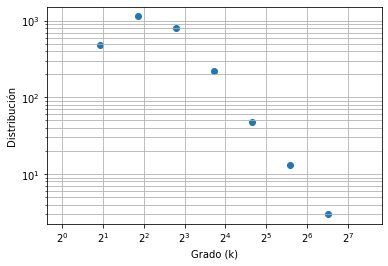

In [40]:
# TODO:  Dibujar histograma de grados, con bins equiespaciados en escala
# logarítmica.

############# Tu código acá #############
log_base = 2
linspace = np.logspace(0, np.log10(max(deg_sequence)) / np.log10(log_base), 10, base=log_base)
log_hist_degree_distribution, _ = np.histogram(deg_sequence, bins=linspace)

plt.scatter(linspace[:-1], log_hist_degree_distribution)
plt.xscale("log", base=2)
plt.xlabel("Grado (k)")
plt.yscale("log")
plt.ylabel("Distribución")
plt.grid(which='both')
plt.show()

#########################################

### Distribución de Pareto
Con esta elección del histograma debería observar una distribución que parece obedecer a una ley de potencias, al menos para valores de $k$ mayores que cierto valor $k_\text{min}$. Para caracterizar este comportamiento, utilizaremos la distribución de Pareto: una variable aleatoria $X$ se dice que tiene distribución de Pareto si tiene una función de densidad de probabilidad dada por:

$$p(k) = \left\lbrace \begin{array}{c c} C k^{-\alpha} & \text{ si } k\geq k_\text{min} \\ 0 & \text{ en otro caso} \end{array}\right.$$

4. ¿Cuánto tiene que valer la constante $C$ para que $p$ sea efectivamente una densidad?



$$
\int_{0}^{\infty} p(k) dk = \int_{k_{\text{min}}}^{\infty} C k^{-\alpha} dk = C \int_{k_{\text{min}}}^{\infty} k^{-\alpha}dk \\
\int_{0}^{\infty} p(k) dk = C \left[ \frac{k_{\text{min}}^{-\alpha+1}}{-\alpha+1} \right] = 1 \\

\Rightarrow C = \frac{-\alpha+1}{k_{\text{min}}^{-\alpha+1}}

$$

Si tenemos $n$ observaciones independientes $k_1, \dots,k_n$ que provienen de una distribución de Pareto, es fácil probar (ver ejercicio opcional al final del laboratorio) que el estimador de máxima verosimilitud para $\alpha$ es:
$$\hat{\alpha} = 1 + n \left[\sum_{i=1}^n \log \left(\frac{k_i}{k_\text{min}}\right)\right]^{-1}.$$

5. Escribir una función que permita estimar $\alpha$ para un grafo. Estimar ese parámetro para la red de citaciones de papers.

In [41]:
def alpha_maximum_likelihood(degrees_list, k_min):
  # TODO: Implementar esta función que acepta como argumento una lista de los
  # grados de un grafo y el valor del grado mínimo a partir del cual vale la
  # distribución power-law y devuelve la estimación del exponente α

  alpha_hat = 0

  ############# Tu código acá #############

  degrees_list = degrees_list[degrees_list >= k_min]
  alpha_hat = 1 + 1 / np.mean(np.log(degrees_list / k_min))

  #########################################

  return alpha_hat

Calculemos el valor de $\hat{\alpha}$ para la red de citaciones de papers. Si la implementación anterior está bien debería ser cercano a $4$.

In [42]:
k_min = 10
alpha_hat_cora = alpha_maximum_likelihood(deg_sequence, k_min)

print(f"El valor de α para la red de papers es {alpha_hat_cora:.3f}" )

El valor de α para la red de papers es 4.030


### Assortative mixing

En redes sociales, el concepto de *homofilia* ([*homophily*](https://en.wikipedia.org/wiki/Homophily) en inglés) refiere a la tendencia de los nodos a relacionarse con nodos similares. En lenguaje de network science, esta tendencia se denomina *assortative mixing*. Obviamente que esa tendencia depende de qué se entienda por "similaridad" entre nodos.

Una posible medida de similaridad consiste en mirar cuántas conexiones hay entre nodos de la misma clase. Supongamos que tenemos etiquetados a los nodos de una red como pertenecientes a una de $n_c$ clases (es decir, cada nodo $i$ tiene un atributo $c_i\in \{1,\dots,n_c\}$ que indica a cuál de las $n_c$ clases pertenece). Una medida que permite cuantificar el nivel de homofilia de una red es la llamada *modularidad*, definida como:
$$Q = \frac{1}{2m} \sum_{ij} \left(A_{ij} -\frac{k_ik_j}{2m} \right)\delta(c_i,c_j)$$
donde $m$ es la cantidad total de aristas en la red, $A_{ij}$ son las entradas de la matriz de adyacencia, $k_i$ es el grado del nodo $i$ y $\delta(r,p)$ es la delta de Kronecker: $\delta(r,p) = 1$ si $r=p$ y $\delta(r,p) = 0$ si $r\neq p$. La modularidad $Q$ mide la proporción entre cuántas aristas existen en la red uniendo nodos del mismo tipo vs. cuántas aristas existirían entre nodos del mismo tipo si la asignación de conexiones fuese hecha al azar. Es estricamente menor a 1, toma valores positivos si hay más aristas entre nodos del mismo tipo que las esperadas, y negativos en caso contrario.

En esta parte calcularemos el coeficiente de modularidad para el grafo de citaciones y para otro dataset, construido a partir de información de vuelos entre aeropuertos de Estados Unidos.

In [43]:
# Lo mismo de siempre, importo el dataset con PyTorch Geometric
from torch_geometric.datasets import Airports

airports_dataset = Airports(root='/tmp/airports', name='USA')

In [44]:
# Algunos datos del grafo
print(f'Dataset: {airports_dataset}:')
print('======================')
print(f'Cantidad de grafos: {len(airports_dataset)}')
print(f'Cantidad de clases: {airports_dataset.num_classes}')

Dataset: UsaAirports():
Cantidad de grafos: 1
Cantidad de clases: 4


In [45]:
# Miro el primer grafo
airports_data = airports_dataset[0]

print(airports_data)
print('==============================================================')

# Estadísticas del grafo.
print(f'Cantidad de nodos: {airports_data.num_nodes}')
print(f'Cantidad de aristas: {airports_data.num_edges}')
print(f'Grado promedio de nodo: {(2*airports_data.num_edges) / airports_data.num_nodes:.2f}')
print(f'Tiene nodos aislados: {airports_data.has_isolated_nodes()}')
print(f'Tiene self-loops: {airports_data.has_self_loops()}')
print(f'Es no dirigido: {airports_data.is_undirected()}')

Data(x=[1190, 1190], edge_index=[2, 13599], y=[1190])
Cantidad de nodos: 1190
Cantidad de aristas: 13599
Grado promedio de nodo: 22.86
Tiene nodos aislados: False
Tiene self-loops: False
Es no dirigido: False


Los datos para construir el grafo provienen del paper [struc2vec: Learning Node Representations from Structural Identity](https://arxiv.org/pdf/1704.03165.pdf). Los nodos corresponden a aeropuertos, y una arista entre el aeropuerto $i$ y el $j$ indica la existencia de un vuelo comercial de $i$ a $j$ (es un grafo dirigido). Los aeropuertos están etiquetados según su nivel de actividad, medida como la cantidad total de pasajeros que pasaron por ahí en el período de relevamiento de los datos (de enero a octubre de 2016). La asignación está hecha entre 4 clases, calculadas con los cuartiles de la distribución de actividad empírica de los datos. Así, la etiqueta 0 corresponde al 25% de aeropuertos menos activos, y así sucesivamente.

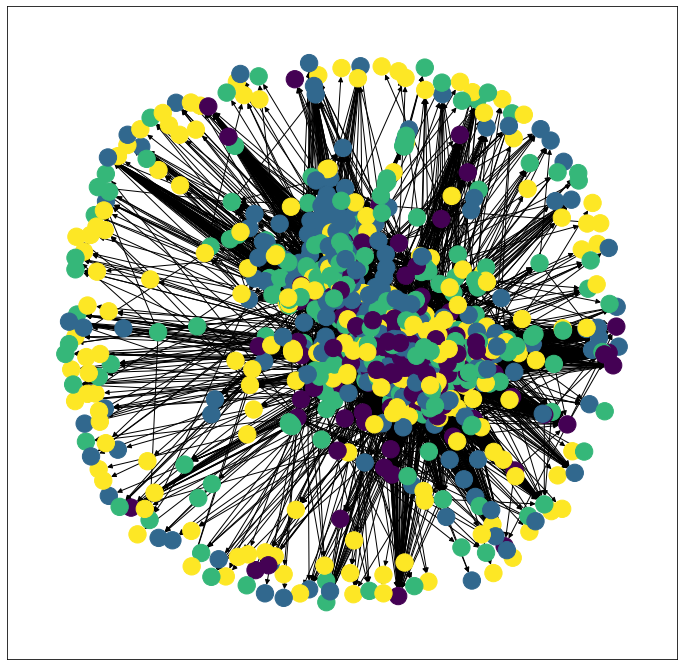

In [17]:
# Dibujo el grafo
G_airports = to_networkx(airports_data)
plt.figure(figsize=(12,12))
airports_pos = nx.spring_layout(G_airports, seed=20)
nx.draw_networkx(G_airports,node_color=airports_data.y,pos=airports_pos,with_labels=False)

6. Calcular la modularidad del grafo de aeropuertos y del grafo de citas entre papers. Para eso puede ser de utilidad la función [`networkx.algorithms.community.modularity`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html) y la función `communities_partition` de abajo.
7. ¿Qué le dicen esos valores sobre la dinámica de las relaciones entre los nodos de cada grafo? ¿Es coherente con el comportamiento que espera de las conexiones entre los nodos de cada red?

In [46]:
def communities_partition(labels):
  # Función que, dada una lista con la asignación de clases de cada nodo de un
  # grafo, devuelve una partición del grafo en esas comunidades

  # Me fijo cuántas comunidades distintas hay
  communities_labels = np.unique(labels)

  # Armo partición del grafo. Ver ejemplo en https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html
  # para entender el formato de lo que devuelve esta función

  partition = [set(np.where(labels == community_idx)[0]) for community_idx in communities_labels]

  return partition

In [47]:
# TODO: calcular la modularidad para el grafo de aeropuertos y el de citas
# entre papers

############# Tu código acá #############
communities_airports = communities_partition(airports_data.y)
modularity_airports = nx.algorithms.community.modularity(G_airports, communities_airports)
print("Modularity of airports graph: ", modularity_airports)

communities_cora = communities_partition(cora_data.y)
modularity_cora = nx.algorithms.community.modularity(G_cora, communities_cora)
print("Modularity of cora graph: ", modularity_cora)
#########################################

Modularity of airports graph:  0.10821045207658975
Modularity of cora graph:  0.6401188105775135


## Detección de (dos) comunidades
En esta parte implementaremos dos algoritmos que vimos en clase para dividir un grafo en dos comunidades: la división espectral (*spectral partitioning*) y la maximización espectral de modularidad (*spectral modularity maximization*). Como su nombre lo indica, son métodos que se basan en la descomposición espectral (i.e. en valores y vectores propios) de alguna matriz. Aplicaremos ambos algoritmos sobre un ejemplo conocido: el Zachary's karate club.


In [20]:
# Levanto la versión del karate club de Networkx, porque tiene la división en
# las dos comunidades originales del paper de Zachary (la versión de PyTorch
# Geometric tiene 4 comunidades)
G_karate = nx.karate_club_graph()

# Cada nodo tiene un atributo 'club' que dice a qué comunidad pertenece
communities_gt = [G_karate.nodes[node]['club'] for node in G_karate.nodes()]
print(f"Comunidades en Zachary's karate club: {np.unique(communities_gt)}")

Comunidades en Zachary's karate club: ['Mr. Hi' 'Officer']


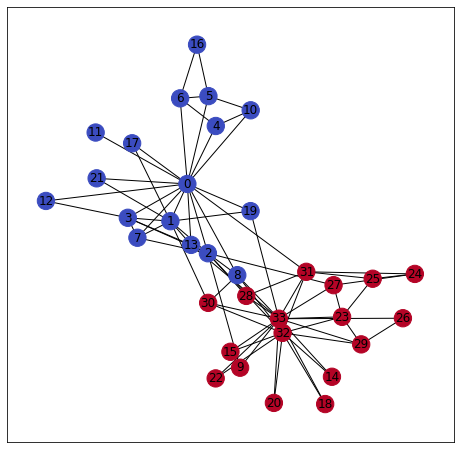

In [21]:
# Networkx define las comunidades con nombre ('Mr. Hi' u 'Officer'). Las
# codifico con dos enteros cualquiera
communities_dict = {'Mr. Hi': -1, 'Officer':1}
communities_gt_int = [communities_dict[gt] for gt in communities_gt]

# Dibujo el grafo con las comunidades en colores
plt.figure(figsize=(8,8))
karate_pos = nx.spring_layout(G_karate, seed=42)
nx.draw_networkx(G_karate,node_color=communities_gt_int,pos=karate_pos,cmap='coolwarm')

### Spectral partitioning
En este contexto, el problema de *particionar* un grafo consiste en dividir el grafo en dos comunidades cuyo tamaño está fijo de antemano. En caso que querramos dividir al grafo en dos comunidades pero sin pre-especificar su tamaño, diremos que estamos resolviendo el problema de *detección de comunidades*. Como su nombre lo indica, el algoritmo de *spectral partitioning* cae en la primera categoría.

8. Implementar el algoritmo de spectral partitioning que vimos en clase, que permita dividir un grafo $G$ en dos comunidades de tamaños $n_1$ y $n_2$ dados.

In [287]:


def spectral_partitioning(G: nx.Graph,n_1: int,n_2: int):
  # TODO: Implementar el algoritmo de spectral partitioning. Esta función acepta
  # como argumento un grafo G de Networkx y dos enteros n_1 y n_2 y devuelve
  # un vector de numpy con la asignación de clases de cada nodo del grafo,
  # codificada con dos enteros distintos. Por ejemplo, a los nodos de la
  # comunidad 1 los codifico con un 1 y a los de la comunidad 2 con un 2. Se
  # puede usar cualquier par de enteros -siempre que sean distintos-.

  communities_assignments = np.zeros((G.number_of_nodes(),))

  ############# Tu código acá #############

  L = nx.laplacian_matrix(G)
  eig_vals, eig_vecs = np.linalg.eig(L.todense())
  v2 = eig_vecs.T[np.argsort(np.abs(eig_vals))[1]]
  v2_argsort = np.argsort(v2, axis=1)

  communities_assignments = np.ones(G.number_of_nodes())
  communities_assignments[v2_argsort[:,-n_1:]] = -1
  #########################################

  return communities_assignments

Si hizo las cosas bien, el algoritmo debería recuperar perfectamente la asignación de clases cuando la división se hace en dos comunidades de igual tamaño.

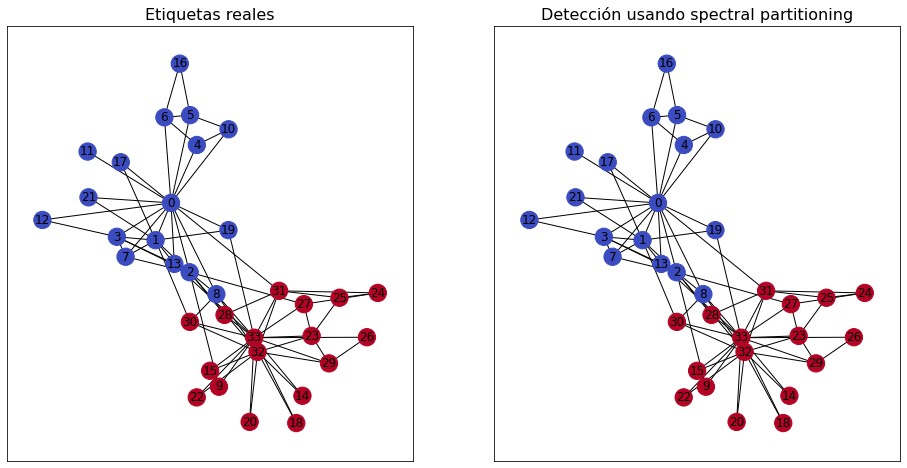

In [289]:
# Divido en comunidades de igual tamaño
n_1 = int(G_karate.number_of_nodes()/2)
n_2 = n_1
karate_partition = spectral_partitioning(G_karate,n_1,n_2)

# Paso etiquetas de la partición a un orden coherente con el del ground truth
karate_partition = remap_labels(communities_gt_int,karate_partition)

# Dibujo grafo con asignación de clases dada por la partición espectral
plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
_= ax1.set_title('Etiquetas reales',fontsize = 16)
nx.draw_networkx(G_karate,node_color=communities_gt_int,pos=karate_pos,ax=ax1,cmap='coolwarm')
ax2 = plt.subplot(1,2,2)
nx.draw_networkx(G_karate,node_color=karate_partition,pos=karate_pos,ax=ax2,cmap='coolwarm')
_= ax2.set_title('Detección usando spectral partitioning',fontsize = 16)

Una forma de medir numéricamente qué tan buena es la asignación de comunidades es mediante el [índice de Rand](https://en.wikipedia.org/wiki/Rand_index). Tiene un máximo de 1, que se da si las asignaciones son iguales.

In [290]:
from sklearn.metrics import adjusted_rand_score
# Usamos el adjusted_rand_score, que está definido de manera tal que si la
# asignación es al azar esperamos obtener un valor cercano a 0 (el índice de
# Rand simple no nos asegura esto)
rand_score_spectral = adjusted_rand_score(communities_gt_int,karate_partition)
print(f"Índice de Rand (ajustado) para el spectral partitioning del karate club: {rand_score_spectral:.3f}")

Índice de Rand (ajustado) para el spectral partitioning del karate club: 1.000


Otra posible medida de qué tan buena es la asignación de comunidades es el [índice de Fowlkes-Mallows](https://scikit-learn.org/stable/modules/clustering.html#fowlkes-mallows-scores), definido como la media geométrica del [precision y el recall](https://en.wikipedia.org/wiki/Precision_and_recall) de la asignación. Este índice va de 0 a 1, y es 1 si las asignaciones son iguales.

In [291]:
from sklearn.metrics import fowlkes_mallows_score
# Convenientemente, sklearn tiene implementados estos índices (y muchos más)
# Ver https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
mallows_score_spectral = fowlkes_mallows_score(communities_gt_int,karate_partition)
print(f"Índice de Fowlkes-Mallows para el spectral partitioning del karate club: {mallows_score_spectral:.3f}")

Índice de Fowlkes-Mallows para el spectral partitioning del karate club: 1.000


Miremos qué nos dice cada índice si la asignación es al azar.

In [292]:
# Asigno etiquetas al azar
random_assignments = np.random.randint(1,size=G_karate.number_of_nodes())

rand_score_random = adjusted_rand_score(communities_gt_int,random_assignments)
mallows_score_random = fowlkes_mallows_score(communities_gt_int,random_assignments)
print(f"Índice de Rand (ajustado) para asignación al azar del karate club: {rand_score_random:.3f}")
print(f"Índice de Fowlkes-Mallows para asignación al azar del karate club: {mallows_score_random:.3f}")

Índice de Rand (ajustado) para asignación al azar del karate club: 0.000
Índice de Fowlkes-Mallows para asignación al azar del karate club: 0.696


### Spectral modularity maximization
Una desventaja del método de partición espectral es que necesitamos conocer de antemano la cantidad de nodos en cada comunidad. El método *spectral modularity maximization* permite detectar dos comunidades sin conocer el tamaño de cada una (es, por lo tanto, un algoritmo de *community detection*).

9. Implementar el algoritmo de spectral modularity maximization que vimos en clase, que permita dividir un grafo $G$ en dos comunidades. La función [`networkx.modularity_matrix`](https://networkx.org/documentation/stable/reference/generated/networkx.linalg.modularitymatrix.modularity_matrix.html) puede ser de utilidad.

In [ ]:
def spectral_modularity_maximization(G: nx.Graph):
  # TODO: Implementar el algoritmo de spectral modularity maximization.
  # Esta función acepta como argumento un grafo G de Networkx y devuelve
  # un vector de numpy con la asignación de clases de cada nodo del grafo,
  # codificada con dos enteros distintos. Por ejemplo, a los nodos de la
  # comunidad 1 los codifico con un 1 y a los de la comunidad 2 con un 2. Se
  # puede usar cualquier par de enteros -siempre que sean distintos-.

  communities_assignments = np.zeros((G.number_of_nodes(),))

  ############# Tu código acá #############

  adj = nx.adjacency_matrix(G)
  d = np.array(list(dict( G.degree() ).values())).reshape(1, -1)
  B = adj - d.T @ d / (2 * G.number_of_edges())

  B = nx.modularity_matrix(G)

  eigh_vals, eigh_vecs = np.linalg.eig(B)
  dominant_eigh_vec = eigh_vecs[:,np.abs(eigh_vals).argmax()]
  dominant_eigh_vec = np.real(dominant_eigh_vec) # parte imaginaria practicamente 0

  communities_assignments = np.sign(dominant_eigh_vec).T
  #########################################

  return np.array(communities_assignments).squeeze()

In [378]:
nx.modularity_matrix(G)[1]

matrix([[ 0.07692308, -0.51923077,  0.42307692,  0.65384615, -0.17307692,
         -0.23076923, -0.23076923,  0.76923077, -0.28846154, -0.11538462,
         -0.17307692, -0.05769231, -0.11538462,  0.71153846, -0.11538462,
         -0.11538462, -0.11538462,  0.88461538, -0.11538462,  0.82692308,
         -0.11538462,  0.88461538, -0.11538462, -0.28846154, -0.17307692,
         -0.17307692, -0.11538462, -0.23076923, -0.17307692, -0.23076923,
          0.76923077, -0.34615385, -0.69230769, -0.98076923]])

In [ ]:
nx.adjacency_matrix()

In [379]:
adj = nx.adjacency_matrix(G)
d = np.array(list(dict( G.degree() ).values())).reshape(1, -1)
B = adj - d.T @ d / (2 * G.number_of_edges())
B[1]

/var/folders/p6/bczkg05n3kjbf6fdy02s4zd40000gn/T/ipykernel_17472/3269451752.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G)


matrix([[ 3.07692308, -0.51923077,  5.42307692,  2.65384615, -0.17307692,
         -0.23076923, -0.23076923,  3.76923077, -0.28846154, -0.11538462,
         -0.17307692, -0.05769231, -0.11538462,  4.71153846, -0.11538462,
         -0.11538462, -0.11538462,  0.88461538, -0.11538462,  1.82692308,
         -0.11538462,  1.88461538, -0.11538462, -0.28846154, -0.17307692,
         -0.17307692, -0.11538462, -0.23076923, -0.17307692, -0.23076923,
          1.76923077, -0.34615385, -0.69230769, -0.98076923]])

En este caso, el algoritmo debería asignar correctamente a todos los nodos menos a uno (el nodo número 8). Es el precio a pagar por no conocer la cantidad de elementos en cada comunidad de antemano.

0
(34, 1)
Índice de Rand (ajustado) para spectral modularity maximization del karate club: 0.005
Índice de Fowlkes-Mallows para spectral modularity maximization del karate club: 0.518


/var/folders/p6/bczkg05n3kjbf6fdy02s4zd40000gn/T/ipykernel_17472/4064757026.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G)


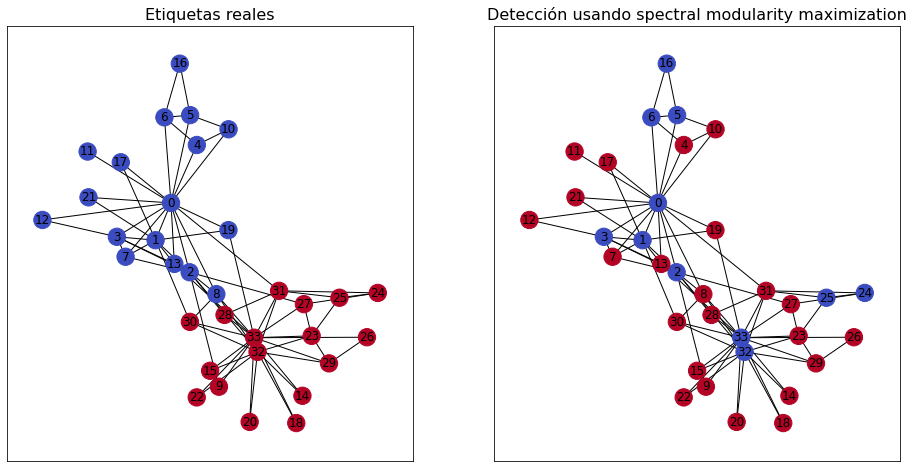

In [361]:
karate_modularity_assingments = spectral_modularity_maximization(G_karate)

# Paso etiquetas de la partición a un orden coherente con el del ground truth
karate_modularity_assingments = remap_labels(communities_gt_int,karate_modularity_assingments)

# Dibujo grafo con asignación dada por el spectral modularity maximization
# El nodo 8 pertenece a la comunidad "de abajo", pero en esta asignación
# debería aparecer como perteneciente a la comunidad de arriba.
plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
_= ax1.set_title('Etiquetas reales',fontsize = 16)
nx.draw_networkx(G_karate,node_color=communities_gt_int,pos=karate_pos,ax=ax1,cmap='coolwarm')
ax2 = plt.subplot(1,2,2)
nx.draw_networkx(G_karate,node_color=karate_modularity_assingments,pos=karate_pos,ax=ax2,cmap='coolwarm')
_= ax2.set_title('Detección usando spectral modularity maximization',fontsize = 16)


# Calculo índices para esta asignación
rand_score_modularity = adjusted_rand_score(communities_gt_int,karate_modularity_assingments)
mallows_score_modularity = fowlkes_mallows_score(communities_gt_int,karate_modularity_assingments)
print(f"Índice de Rand (ajustado) para spectral modularity maximization del karate club: {rand_score_modularity:.3f}")
print(f"Índice de Fowlkes-Mallows para spectral modularity maximization del karate club: {mallows_score_modularity:.3f}")

### Detección de orientación política de blogs
Por último, vamos a detectar comunidades en un dataset real. Se trata de datos de blogs sobre política estadounidense, en un momento cercano a la elección del 2004 en ese país. Proviene del paper [The Political Blogosphere and the 2004 US Election: Divided they Blog](https://dl.acm.org/doi/10.1145/1134271.1134277).

Cada nodo del grafo corresponde a un blog, y hay una arista del nodo $i$ al nodo $j$ si el blog $i$ tiene un link al nodo $j$. Es por lo tanto un grafo dirigido; para esta parte lo convertiremos a no dirigido: simplemente, ponemos una arista entre $i$ y $j$ en el grafo no dirigido si en la versión dirigida existe una arista que une $i$ con $j$ en alguna dirección. Cada blog está etiquetado según su afiliación a uno de los dos grandes partidos de la política estadounidense.

In [ ]:
# El dataset está disponible en PyTorch Geometric. Lo importamos como siempre
from torch_geometric.datasets import PolBlogs

blogs_dataset = PolBlogs(root='/tmp/polblogs')

In [ ]:
# Características del dataset. Hay un solo grafo y 2 clases de blogs
print(f'Dataset: {blogs_dataset}:')
print('======================')
print(f'Cantidad de grafos: {len(blogs_dataset)}')
print(f'Cantidad de clases: {blogs_dataset.num_classes}')

In [ ]:
# Miro el único grafo que hay
blogs_data = blogs_dataset[0]

print(blogs_data)
print('==============================================================')

# Algunas estadísticas
print(f'Cantidad de nodos: {blogs_data.num_nodes}')
print(f'Cantidad de aristas: {blogs_data.num_edges}')
print(f'Grado promedio de nodo: {(2*blogs_data.num_edges) / blogs_data.num_nodes:.2f}')
print(f'Tiene nodos aislados: {blogs_data.has_isolated_nodes()}')
print(f'Tiene self-loops: {blogs_data.has_self_loops()}')
print(f'Es no dirigido: {blogs_data.is_undirected()}')

Vemos que el grafo es dirigido y además tiene auto aristas (aristas que van de un nodo a sí mismo). Lo vamos a convertir a no dirigido y vamos a quitar las auto-aristas. Además, no es un grafo conexo; vamos a hacer detección de comunidades en la componente conexa más grande del grafo.

In [ ]:
# Convierto el grafo a no dirigido usando Networkx porque PyG lo convierte
# usando solo la parte triangular superior o inferior de la adyacencia.
G_blogs = to_networkx(blogs_data, to_undirected=False)
G_blogs = G_blogs.to_undirected()

# Me quedo solo con la componente conexa más grande
largest_cc_nodes = max(nx.connected_components(G_blogs), key=len)
G_lcc = G_blogs.subgraph(largest_cc_nodes).copy()

# Le saco los self loops
G_lcc.remove_edges_from(nx.selfloop_edges(G_lcc))

# Me quedo con las etiquetas de la componente conexa más grande
G_lcc_labels = blogs_data.y[list(largest_cc_nodes)]

# Dibujo el grafo
G_lcc_pos = nx.spring_layout(G_lcc, seed=20)
plt.figure(figsize=(12,12))
nx.draw_networkx(G_lcc,node_color=G_lcc_labels,pos=G_lcc_pos,with_labels=False)

Como en un dataset real en general no conocemos la cantidad de elementos que tiene cada comunidad, vamos a hacer detección de comunidades usando spectral modularity maximization.

In [ ]:
# Hago detección de comunidades usando implementación de spectral modularity
# maximization
mod_max_blogs = spectral_modularity_maximization(G_lcc)
# Paso etiquetas de la partición a un orden coherente con el del ground truth
mod_max_blogs = remap_labels(G_lcc_labels,mod_max_blogs)

# Dibujo comunidades reales y comunidades detectadas
plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,2,1)
_= ax1.set_title('Etiquetas reales',fontsize = 16)
nx.draw_networkx(G_lcc,node_color=G_lcc_labels,pos=G_lcc_pos,with_labels=False,ax=ax1)
ax2 = plt.subplot(1,2,2)
nx.draw_networkx(G_lcc,node_color=mod_max_blogs,pos=G_lcc_pos,with_labels=False,ax=ax2)
_= ax2.set_title('Detección usando spectral modularity maximization',fontsize = 16)

Miro qué dicen los indicadores sobre la detección de comunidades. Debería dar algo cercano a 1 en ambos casos.

In [ ]:
rand_score_blogs = adjusted_rand_score(G_lcc_labels, mod_max_blogs)
mallows_score_blogs = fowlkes_mallows_score(G_lcc_labels,mod_max_blogs)
print(f"Índice de Rand (ajustado) para spectral modularity maximization de blogs políticos: {rand_score_blogs:.3f}")
print(f"Índice de Fowlkes-Mallows para spectral modularity maximization de blogs políticos: {mallows_score_blogs:.3f}")

10. ¿Qué diferencias cualitativas ve entre las figuras de arriba? ¿Le dice esto algo sobre las limitaciones del método de spectral modularity maximization?

## (Opcional) Estimador de máxima verosimilitud para el exponente de la distribución de Pareto

La idea de este ejercicio es demostrar la fórmula del estimador de máxima verosimilitud que usamos antes para el exponente de la distribución de Pareto. Quienes lo entreguen (correctamente resuelto) tendrán puntos extra en el laboratorio.

1. Supongamos que tenemos $n$ observaciones independientes $k_1, \dots,k_n$ que provienen de la distribución de Pareto. Demostrar que la función de log-verosimilitud está dada por:
$$\mathcal{l}_n(\alpha) = n \log (\alpha -1)-n\log k_\text{min} - \alpha \sum_{i=1}^n \log \left(\frac{k_i}{k_\text{min}}\right).$$

2. Concluir que el estimador de máxima verosimilitud para $\alpha$ es:
$$\hat{\alpha} = 1 + n \left[\sum_{i=1}^n \log \left(\frac{k_i}{k_\text{min}}\right)\right]^{-1}.$$